In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

2024-06-04 07:01:19.003462: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 07:01:19.003554: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 07:01:19.003578: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-04 07:01:19.011363: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('dataset/windows/windowed_2.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810624 entries, 0 to 810623
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   time    810624 non-null  int64 
 1   A_F     810624 non-null  int64 
 2   A_V     810624 non-null  int64 
 3   A_L     810624 non-null  int64 
 4   L_F     810624 non-null  int64 
 5   L_V     810624 non-null  int64 
 6   L_L     810624 non-null  int64 
 7   T_F     810624 non-null  int64 
 8   T_V     810624 non-null  int64 
 9   T_L     810624 non-null  int64 
 10  Action  810624 non-null  int64 
 11  name    810624 non-null  object
dtypes: int64(11), object(1)
memory usage: 74.2+ MB


In [4]:
# 'name' 열에서 2, 3번째 숫자를 추출하여 새로운 열 'user_number' 생성
df['user_number'] = df['name'].str[1:3]

# 'user_number' 열을 int형으로 변환
df['user_number'] = df['user_number'].astype(int)

# 기존 'name' 열 삭제
df.drop(columns=['name'], inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810624 entries, 0 to 810623
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   time         810624 non-null  int64
 1   A_F          810624 non-null  int64
 2   A_V          810624 non-null  int64
 3   A_L          810624 non-null  int64
 4   L_F          810624 non-null  int64
 5   L_V          810624 non-null  int64
 6   L_L          810624 non-null  int64
 7   T_F          810624 non-null  int64
 8   T_V          810624 non-null  int64
 9   T_L          810624 non-null  int64
 10  Action       810624 non-null  int64
 11  user_number  810624 non-null  int64
dtypes: int64(12)
memory usage: 74.2 MB


In [6]:
print(df.dtypes)

time           int64
A_F            int64
A_V            int64
A_L            int64
L_F            int64
L_V            int64
L_L            int64
T_F            int64
T_V            int64
T_L            int64
Action         int64
user_number    int64
dtype: object


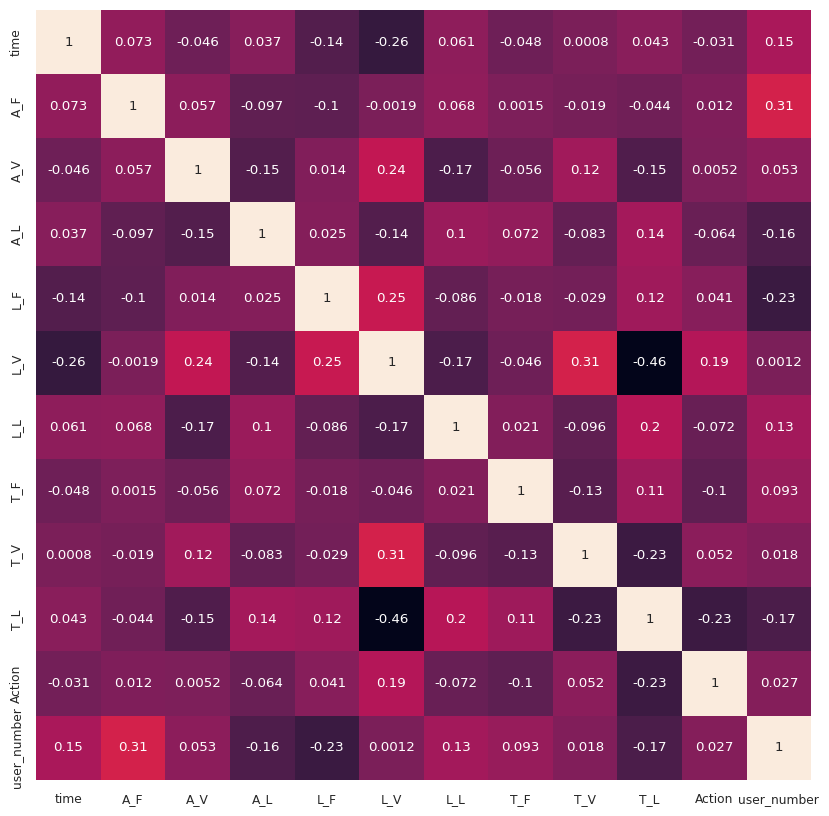

In [7]:
# 히트맵 그리기
df_corr = df.corr()

# 히트맵 그리기
plt.figure(figsize=(10, 10))
sns.set(font_scale=0.8)
mask = np.zeros(df_corr.shape, dtype=bool)  # 여기에 문제가 있을 수 있습니다.
sns.heatmap(df_corr, annot=True, cbar=False, mask=mask)
plt.show()

In [8]:
df.shape

(810624, 12)

In [9]:
df['Action'].value_counts()

0    677184
1    103104
2     30336
Name: Action, dtype: int64

In [10]:
# status 열에서 값이 0인 행 제거
df = df[df['Action'] != 0]

# status 열에서 값이 1인 행을 0으로, 값이 2인 행을 1로 바꾸기
df['Action'] = df['Action'].replace({1: 0, 2: 1})

In [11]:
df['Action'].value_counts()

0    103104
1     30336
Name: Action, dtype: int64

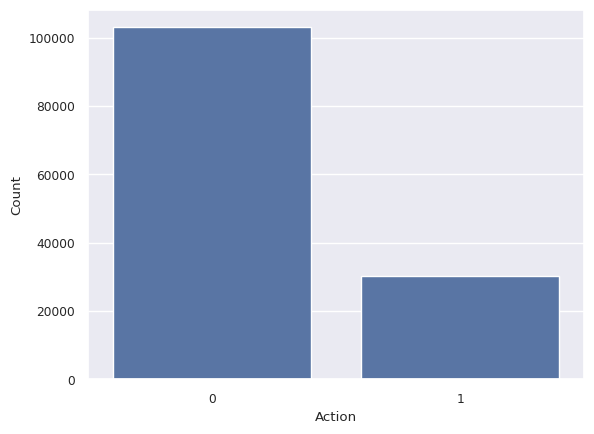

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and '0' is the column name
# Ensure the column is of categorical dtype
df['Action'] = df['Action'].astype('category')

# Now plot
sns.countplot(data=df, x="Action")
plt.xlabel("Action")
plt.ylabel("Count")
plt.show()

In [13]:
def split_sequence(X, y, n_steps):
    X_seq, y_seq = list(), list()
    for i in range(len(X) - n_steps + 1):
        end_ix = i + n_steps
        seq_x = X[i:end_ix]
        seq_y = y[end_ix-1]
        X_seq.append(seq_x)
        y_seq.append(seq_y)
    return np.array(X_seq), np.array(y_seq)

In [14]:
X = df[['A_L', 'L_V', 'L_L', 'T_F','T_L']]
y = df['Action'].to_numpy()

In [15]:
n_steps = 6

In [16]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [17]:
X, y = split_sequence(X, y, n_steps)

In [18]:
Y = to_categorical(y)
Y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [19]:
X_train, X_test, y_train, y_test =  train_test_split(X, Y, test_size = 0.2, random_state = 0, stratify = y)

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train , test_size = 0.2, random_state = 0, stratify = y_train)

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((85398, 6, 5), (26687, 6, 5), (85398, 2), (26687, 2))

In [22]:
n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train.shape[1]

In [23]:
model = keras.Sequential()
model.add(keras.layers.Dense(50, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Dense(100, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(n_outputs, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6, 50)             300       
                                                                 
 dense_1 (Dense)             (None, 6, 100)            5100      
                                                                 
 dense_2 (Dense)             (None, 6, 150)            15150     
                                                                 
 dense_3 (Dense)             (None, 6, 200)            30200     
                                                                 
 batch_normalization (Batch  (None, 6, 200)            800       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 6, 200)            0         
                                                        

In [24]:
print(f"X_train type: {type(X_train)}")
print(f"y_train type: {type(y_train)}")
print(f"X_val type: {type(X_val)}")
print(f"y_val type: {type(y_val)}")

X_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>
X_val type: <class 'numpy.ndarray'>
y_val type: <class 'numpy.ndarray'>


In [25]:
# 데이터 타입 확인
print("Checking data types...")
print(f"X_train dtype: {X_train.dtype}")
print(f"y_train dtype: {y_train.dtype}")
print(f"X_val dtype: {X_val.dtype}")
print(f"y_val dtype: {y_val.dtype}")

Checking data types...
X_train dtype: float64
y_train dtype: float32
X_val dtype: float64
y_val dtype: float32


In [26]:
epochs, batch_size = 100, 64
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val), shuffle=True, callbacks=callbacks)

Epoch 1/100
1335/1335 [==============================] - 9s 6ms/step - loss: 0.5422 - accuracy: 0.7637 - val_loss: 0.5142 - val_accuracy: 0.7742
Epoch 2/100
1335/1335 [==============================] - 8s 6ms/step - loss: 0.5105 - accuracy: 0.7736 - val_loss: 0.5111 - val_accuracy: 0.7717
Epoch 3/100
1335/1335 [==============================] - 8s 6ms/step - loss: 0.5023 - accuracy: 0.7758 - val_loss: 0.4996 - val_accuracy: 0.7792
Epoch 4/100
1335/1335 [==============================] - 8s 6ms/step - loss: 0.4948 - accuracy: 0.7799 - val_loss: 0.4916 - val_accuracy: 0.7807
Epoch 5/100
1335/1335 [==============================] - 8s 6ms/step - loss: 0.4864 - accuracy: 0.7827 - val_loss: 0.4887 - val_accuracy: 0.7814
Epoch 6/100
1335/1335 [==============================] - 8s 6ms/step - loss: 0.4792 - accuracy: 0.7851 - val_loss: 0.4832 - val_accuracy: 0.7874
Epoch 7/100
1335/1335 [==============================] - 8s 6ms/step - loss: 0.4722 - accuracy: 0.7882 - val_loss: 0.4708 - val_ac

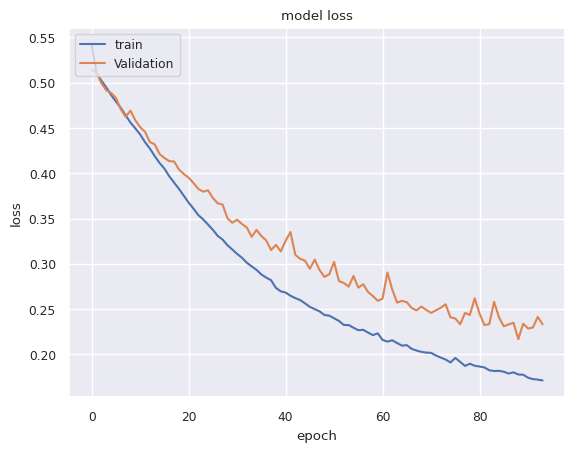

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

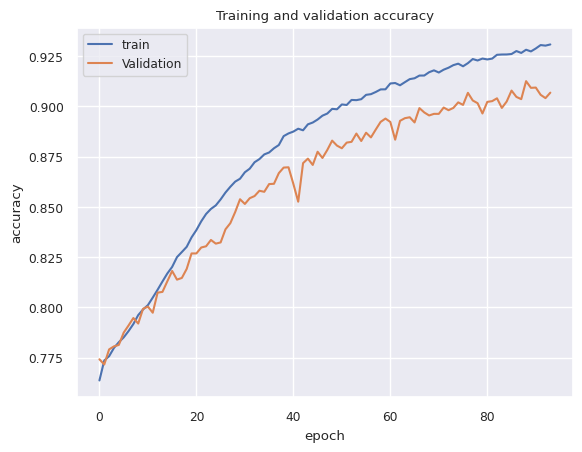

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

834/834 [==============================] - 1s 1ms/step
f1_score =  0.9095860571184984
0.9106681155618841
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     20620
           1       0.82      0.77      0.80      6067

    accuracy                           0.91     26687
   macro avg       0.88      0.86      0.87     26687
weighted avg       0.91      0.91      0.91     26687



(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

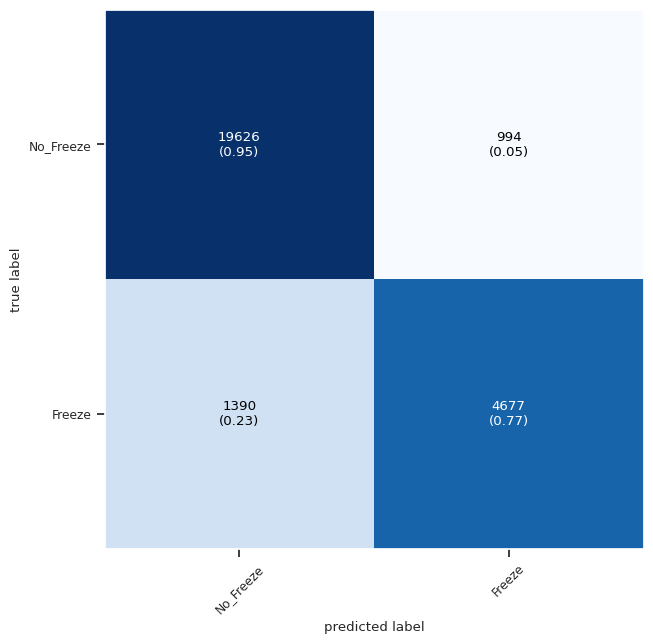

In [29]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import numpy as np

# 모델 예측
predy = model.predict(X_test)
predy = np.argmax(predy, axis=-1)
y_true = np.argmax(y_test, axis=-1)

LABELS = ['No_Freeze', 'Freeze']
cm = confusion_matrix(y_true, predy)

# 결과 출력
print('f1_score = ', f1_score(y_true, predy, average='weighted'))
print(accuracy_score(y_true, predy))
print(classification_report(y_true, predy))

# 혼동 행렬 시각화
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7, 7))

### SMOTE() 오버 샘플링

In [30]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(df.drop('Action', axis=1), df['Action'])

In [31]:
df = pd.concat([pd.DataFrame(X_resampled, columns=df.drop('Action', axis=1).columns),
                         pd.DataFrame({'Action': y_resampled})], axis=1)

In [32]:
print(df['Action'].value_counts())

0    103104
1    103104
Name: Action, dtype: int64


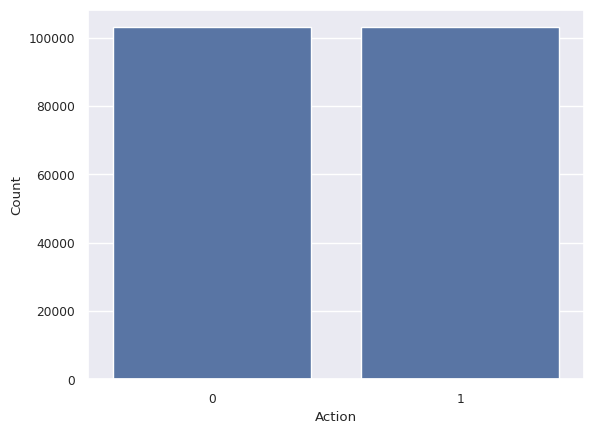

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and '0' is the column name
# Ensure the column is of categorical dtype
df['Action'] = df['Action'].astype('category')

# Now plot
sns.countplot(data=df, x="Action")
plt.xlabel("Action")
plt.ylabel("Count")
plt.show()

In [34]:
X = df[['A_L', 'L_V', 'L_L', 'T_F', 'T_L']]
y = df['Action'].to_numpy()

In [35]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [36]:
X, y = split_sequence(X, y, n_steps)

In [37]:
Y = to_categorical(y)
Y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [38]:
X_train, X_test, y_train, y_test =  train_test_split(X, Y, test_size = 0.2, random_state = 0, stratify = y)

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train , test_size = 0.2, random_state = 0, stratify = y_train)

In [40]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((131969, 6, 5), (41241, 6, 5), (131969, 2), (41241, 2))

In [41]:
n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train.shape[1]

In [42]:
model = keras.Sequential()
model.add(keras.layers.Dense(50, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Dense(100, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(n_outputs, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 6, 50)             300       
                                                                 
 dense_6 (Dense)             (None, 6, 100)            5100      
                                                                 
 dense_7 (Dense)             (None, 6, 150)            15150     
                                                                 
 dense_8 (Dense)             (None, 6, 200)            30200     
                                                                 
 batch_normalization_1 (Bat  (None, 6, 200)            800       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 6, 200)            0         
                                                      

In [43]:
epochs, batch_size = 100, 64
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val), shuffle=True, callbacks=callbacks)

Epoch 1/100
2063/2063 [==============================] - 13s 6ms/step - loss: 0.6950 - accuracy: 0.5979 - val_loss: 0.6699 - val_accuracy: 0.6103
Epoch 2/100
2063/2063 [==============================] - 12s 6ms/step - loss: 0.6572 - accuracy: 0.6312 - val_loss: 0.6461 - val_accuracy: 0.6412
Epoch 3/100
2063/2063 [==============================] - 12s 6ms/step - loss: 0.6462 - accuracy: 0.6436 - val_loss: 0.7264 - val_accuracy: 0.6119
Epoch 4/100
2063/2063 [==============================] - 12s 6ms/step - loss: 0.6362 - accuracy: 0.6522 - val_loss: 0.6672 - val_accuracy: 0.5529
Epoch 5/100
2063/2063 [==============================] - 12s 6ms/step - loss: 0.6282 - accuracy: 0.6590 - val_loss: 0.6209 - val_accuracy: 0.6614
Epoch 6/100
2063/2063 [==============================] - 12s 6ms/step - loss: 0.6214 - accuracy: 0.6643 - val_loss: 0.6151 - val_accuracy: 0.6671
Epoch 7/100
2063/2063 [==============================] - 12s 6ms/step - loss: 0.6126 - accuracy: 0.6706 - val_loss: 0.6155 -

Epoch 57/100
2063/2063 [==============================] - 12s 6ms/step - loss: 0.4429 - accuracy: 0.7880 - val_loss: 0.4669 - val_accuracy: 0.7780
Epoch 58/100
2063/2063 [==============================] - 12s 6ms/step - loss: 0.4438 - accuracy: 0.7892 - val_loss: 0.4597 - val_accuracy: 0.7857
Epoch 59/100
2063/2063 [==============================] - 12s 6ms/step - loss: 0.4389 - accuracy: 0.7919 - val_loss: 0.4549 - val_accuracy: 0.7831
Epoch 60/100
2063/2063 [==============================] - 12s 6ms/step - loss: 0.4435 - accuracy: 0.7890 - val_loss: 0.4625 - val_accuracy: 0.7789
Epoch 61/100
2063/2063 [==============================] - 12s 6ms/step - loss: 0.4401 - accuracy: 0.7922 - val_loss: 0.4624 - val_accuracy: 0.7854
Epoch 62/100
2063/2063 [==============================] - 12s 6ms/step - loss: 0.4358 - accuracy: 0.7930 - val_loss: 0.4541 - val_accuracy: 0.7919
Epoch 63/100
2063/2063 [==============================] - 12s 6ms/step - loss: 0.4331 - accuracy: 0.7944 - val_loss: 0

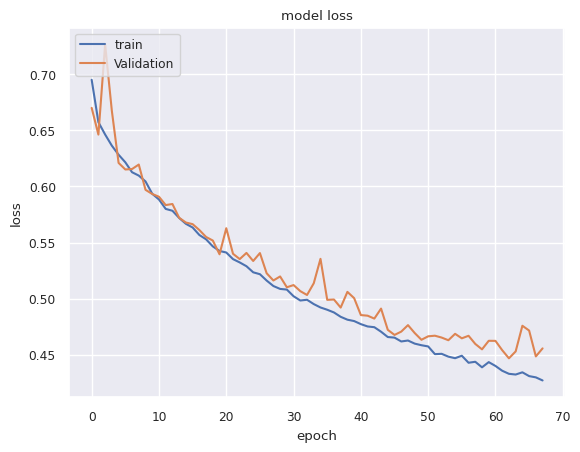

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

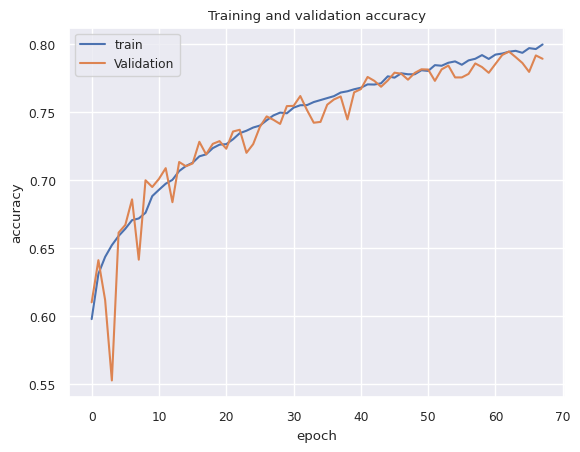

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

1289/1289 [==============================] - 2s 1ms/step
f1_score =  0.7967199593531595
0.7967314080647899
              precision    recall  f1-score   support

           0       0.80      0.79      0.80     20620
           1       0.79      0.80      0.80     20621

    accuracy                           0.80     41241
   macro avg       0.80      0.80      0.80     41241
weighted avg       0.80      0.80      0.80     41241



(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

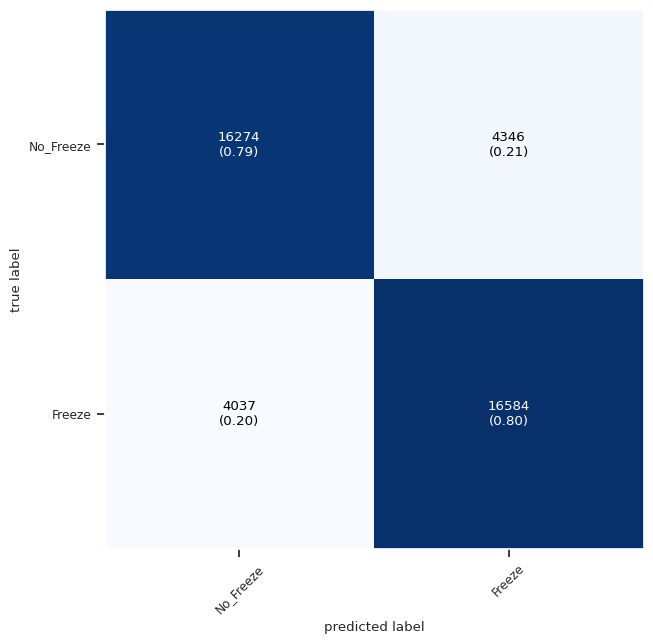

In [46]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import numpy as np

# 모델 예측
predy = model.predict(X_test)
predy = np.argmax(predy, axis=-1)
y_true = np.argmax(y_test, axis=-1)

LABELS = ['No_Freeze', 'Freeze']
cm = confusion_matrix(y_true, predy)

# 결과 출력
print('f1_score = ', f1_score(y_true, predy, average='weighted'))
print(accuracy_score(y_true, predy))
print(classification_report(y_true, predy))

# 혼동 행렬 시각화
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7, 7))